# Data Delivery

This notebook contains a workflow to:
1. Create a NetCDF file containing the outgoing solar radiation data required by the Reflective Earth ROM backend.
1. Create a raster image file (Cloud Optimized GeoTIFF) containing the same data for upload to the Mapbox tiling service.

## Specifications

The Reflective Earth ROM backend requires a NetCDF3 file with latitude and longitude spanning the globe every 0.1 degree (90 to -90 and 0 to 359.9). Following the ERA5 grid, the equator is set to a very small number offset from 0 very slightly. The data format should be the built-in python `float` type to allow for JSON serialization.

Mapbox [requires](https://docs.mapbox.com/help/troubleshooting/uploads/#tiff-uploads) that uploaded TIFF files be 8-bit GeoTIFFs with georeferencing information. Data should be reprojected to Web Mercator (EPSG:3857) with a blocksize of 256 by 256 and use LZW compression, if any.

## Preliminaries

### Requirements

* A Google Cloud project with Cloud Storage enabled ([Create new account](https://cloud.google.com/))
* Python packages. See `environments` directory for platform and notebook specific environment files.

### Imports

In [1]:
from utils import check_environment

check_environment("deliver")

import logging
import multiprocessing
import os
from sys import platform

from google.cloud import storage
from matplotlib import cm
import numpy as np
import rasterio
from rasterio.crs import CRS
from rasterio.plot import show
from rasterio.warp import reproject, Resampling, calculate_default_transform
import xarray as xr
import xesmf as xe

### Setup

In [2]:
data_bucket = "rom-input"
data_dir = "../assets"
n_jobs = -2  # for parallelization; if 1, then serial; if negative, then (n_cpus + 1 + n_jobs) are used

# Xarray configuration
xr.set_options(keep_attrs=True)

# Multiprocessing configuration for MacOS
if platform == "darwin":
    multiprocessing.set_start_method("fork", force=True)  # ipython bug workaround https://github.com/ipython/ipython/issues/12396

# Logging configuration
logging.basicConfig(filename="deliver.log", filemode="w", level=logging.INFO)

## Functions

In [3]:
def get_data_gcs(bucket_name, file_name, file_path="."):
    """Download a dataset for a single date from Google Cloud Storage.
    
    Args:
        bucket_name: Google Cloud Storage bucket to download from.
        file_name: name of file to download from gcs.
        file_path: local path to download the file.
    
    Returns:
        Nothing; downloads data from Google Cloud Storage.
    """
    if os.path.exists(os.path.join(file_path, file_name)):
        logging.info(f"{file_name} already exists locally; skipping GCS download.")
    else:
        client = storage.Client()
        bucket = client.get_bucket(bucket_name)    
        blob = bucket.blob(file_name)
        blob.download_to_filename(filename=os.path.join(file_path, file_name))

## Workflow

### 1. NetCDF file

First we download the data resulting from the analysis featured in the previous notebook.

In [4]:
get_data_gcs(data_bucket, "rom_analysis.nc", data_dir)

The Reflectivity Optimization Map backend specifies a latitude coordinate `lat` and a longitude coordinate `lon`, so these dimensions must be renamed in our dataset:

In [5]:
ds_analysis = xr.open_dataset(os.path.join(data_dir, "rom_analysis.nc"))
ds_analysis = ds_analysis.rename_dims({"latitude": "lat",
                                       "longitude": "lon"}).rename_vars({"latitude": "lat",
                                                                         "longitude": "lon"})

In [6]:
ds_analysis

<xarray.Dataset>
Dimensions:  (lon: 1440, lat: 721)
Coordinates:
  * lon      (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
Data variables: (12/13)
    ssrd     (lat, lon) float32 ...
    tisr     (lat, lon) float32 ...
    tosr     (lat, lon) float32 ...
    ssru     (lat, lon) float32 ...
    R        (lat, lon) float32 ...
    T        (lat, lon) float32 ...
    ...       ...
    alpha    (lat, lon) float32 ...
    a        (lat, lon) float32 ...
    r        (lat, lon) float32 ...
    t        (lat, lon) float32 ...
    srosr    (lat, lon) float32 ...
    psrosr   (lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-06-03 18:12:12 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...
    institution:  ECMWF
    source:       ERA5
    title:        Reflective Earth optimization map inputs
    comment:      Hourly-mean ERA5 boundary solar radiation fields were avera...

The analyzed ROM data are regridded according to the Reflective Earth backend specifications, every 0.1 degree of latitude and longitude:

In [7]:
lats = np.linspace(90.0, -90.0, 1801, dtype=float)
lats[900] = 8.3591467e-13  # an equator=0.0 produces incompatibility with some systems
lons = np.linspace(0.0, 359.9, 3600, dtype=float)

ds_out = xr.Dataset({"lat": (["lat"], lats),
                     "lon": (["lon"], lons)})

In [8]:
regridder = xe.Regridder(ds_analysis, ds_out, "bilinear", 
                         periodic=True, reuse_weights=False)
ds_rom_input = regridder(ds_analysis)

/Users/bsmoliak/miniconda3/envs/deliver/lib/python3.8/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [9]:
ds = xr.Dataset({"psrosr": (["lat", "lon"], ds_rom_input.psrosr.astype(float).data)},
                coords={"lat": (["lat"], ds_rom_input.lat.data),
                        "lon": (["lon"], ds_rom_input.lon.data)})

In [10]:
assert ds.psrosr.data.dtype == float
assert ds.lat.data.size == 1801
assert ds.lon.data.size == 3600

Variable and coordinate attributes are used to store standard metadata for the data, following the CF Conventions.

In [11]:
ds.lat.attrs["long_name"] = "latitude"
ds.lat.attrs["units"] = "degrees_north"
ds.lat.attrs["standard_name"] = "latitude"

In [12]:
ds.lon.attrs["long_name"] = "longitude"
ds.lon.attrs["units"] = "degrees_east"
ds.lon.attrs["standard_name"] = "longitude"

In [13]:
ds.psrosr.attrs["long_name"] = "potential surface-reflected outgoing solar radiation"
ds.psrosr.attrs["units"] = "W m**-2"
ds.psrosr.attrs["standard_name"] = "toa_outgoing_shortwave_flux"

Global attributes are used to store standard metadata for the dataset, again following the CF Conventions.

In [14]:
ds.attrs["title"] = "Reflectivity Optimization Map"
ds.attrs["institution"] = "Reflective Earth Foundation"
ds.attrs["source"] = "ERA5 (ECMWF Copernicus Climate Change Service)"
ds.attrs["history"] = ("v0.4.1 - 20210729 - Update reflected radiation model (Stephens et al. 2015)\n"
                       "v0.4.0 - 20210728 - Updated 1991-2020 Long-term-mean Outgoing Solar Radiation\n"
                       "v0.3.0 - 20200901 - Updated 1990-2019 Long-term-mean Outgoing Solar Radiation\n"
                       "v0.2.0 - 20200610 - Updated 2017-2019 Long-term-mean Outgoing Solar Radiation\n"
                       "v0.1.2 - 20200516 - Updated 201901 Monthly-mean Outgoing Solar Radiation\n"
                       "v0.1.1 - 20200512 - Updated 20190101 Daily-mean Outgoing Solar Radiation\n"
                       "v0.1.0 - 20200511 - Initialized 20190101 (00 UTC) TOA Incoming Solar Radiation")

In [15]:
ds

<xarray.Dataset>
Dimensions:  (lat: 1801, lon: 3600)
Coordinates:
  * lat      (lat) float64 90.0 89.9 89.8 89.7 89.6 ... -89.7 -89.8 -89.9 -90.0
  * lon      (lon) float64 0.0 0.1 0.2 0.3 0.4 ... 359.5 359.6 359.7 359.8 359.9
Data variables:
    psrosr   (lat, lon) float64 34.67 34.67 34.67 34.67 ... 72.15 72.15 72.15
Attributes:
    title:        Reflectivity Optimization Map
    institution:  Reflective Earth Foundation
    source:       ERA5 (ECMWF Copernicus Climate Change Service)
    history:      v0.4.1 - 20210729 - Update reflected radiation model (Steph...

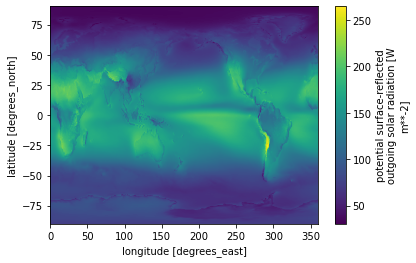

In [16]:
ds.psrosr.plot()

Recall that the Reflective Earth backend server calls for a NetCDF3 file.

In [17]:
ds.to_netcdf(os.path.join(data_dir, "REF_ROM.nc"), format="NETCDF3_64BIT")

### 2. Raster image file

The input dataset needs to have longitude between -180 and 180°E, possibly requiring the data to be reordered for rasterization.

In [18]:
lon_name = "lon"  # whatever name is in the data

ds["_longitude_adjusted"] = xr.where(
    ds[lon_name] > 180,
    ds[lon_name] - 360,
    ds[lon_name])

ds = (
    ds
    .swap_dims({lon_name: "_longitude_adjusted"})
    .sel(**{"_longitude_adjusted": sorted(ds._longitude_adjusted)})
    .drop(lon_name)
    .rename({"_longitude_adjusted": lon_name}))

Next we normalize the data by the intended colormap maximum and convert it to unsigned integers. Where the data are less than the colormap maximum, we multiply the normalized data by 255 (the maximum 8 bit unsigned integer). Where the data are greater than or equal to the colormap maximum, we assign 255.

In [19]:
cmap_max = 250  # watts per square meter
Z = xr.where((ds.psrosr.values / cmap_max) < 1, 
             (ds.psrosr.values / cmap_max) * 255, 255).astype("uint8")

To ensure fidelity to the specifications, we make some assertions:

In [20]:
assert Z.max() == 255  # Largest 8-bit unsigned integer
assert Z.shape == (1801, 3600)  # Shape of input data from NetCDF

src_crs = CRS.from_string("+proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0")
dst_crs = CRS.from_string("EPSG:4326")
proj_crs = CRS.from_string("EPSG:3857")

assert src_crs.is_geographic
assert not dst_crs.is_projected
assert proj_crs.is_projected

We'll use viridis as the primary colormap.

In [21]:
viridis = cm.get_cmap("viridis", 255)
viridis_cm = viridis(np.linspace(0, 1, 255)) * 255

viridis_cmap = {}
for i in range(0, 255):
    viridis_cmap[i+1] = tuple(viridis_cm[i, :])

Next we write the input data to a GeoTIFF using the WGS84 coordinate reference system (EPSG:4326) and display the resulting map:

In [22]:
with rasterio.open(os.path.join(data_dir, "REF_ROM_EPSG4326.tif"), "w",
    driver="GTiff",
    height=Z.shape[0],
    width=Z.shape[1],
    count=1,
    dtype=Z.dtype,
    crs=dst_crs,
    transform=rasterio.transform.from_origin(-180.0, 90.0, 0.1, 0.1)) as dst:
        dst.write_colormap(1, viridis_cmap)
        dst.write(Z, 1)

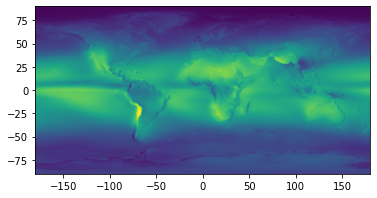

In [23]:
with rasterio.open(os.path.join(data_dir, "REF_ROM_EPSG4326.tif"), "r") as data:
    show(data)

Then we reproject the data to Web Mercator (EPSG:3857) and display the new map.

In [24]:
with rasterio.open(os.path.join(data_dir, "REF_ROM_EPSG4326.tif")) as src:      
    profile = src.profile
    
    transform, width, height = calculate_default_transform(
        src.crs, proj_crs, width=src.width, height=src.height,
        left=-180, bottom=-85.05, right=180, top=85.05)

    profile.update({
        "dtype": rasterio.uint8,
        "count": 1,
        "crs": proj_crs,
        "transform": transform,
        "width": width,
        "height": height,
        "compress": 'lzw',
        "tiled": True,
        "blockxsize": 256,
        "blockysize": 256})
        
    with rasterio.open(os.path.join(data_dir, "REF_ROM_EPSG3857.tif"), "w",
        **profile) as dst:
            dst.write_colormap(1, viridis_cmap)
            reproject(
                source=rasterio.band(src, 1),
                destination=rasterio.band(dst, 1),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=proj_crs,
                resampling=Resampling.nearest)

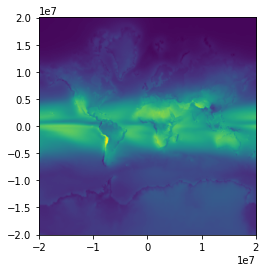

In [25]:
with rasterio.open(os.path.join(data_dir, "REF_ROM_EPSG3857.tif"), "r") as data:
    show(data)

Although we now have a GeoTIFF with data projected to Web Mercator, the Mapbox tiling service requires a [Cloud Optimized GeoTIFF](https://www.cogeo.org/) (COG). This format has an internal structure that enables more efficient workflows in the cloud. GDAL CLI tools can be used to create a COG file. First, we use `gdaladdo` to generate overview images at specified zoom levels. Then we use `gdal_translate` to create a COG file that is tiled, compressed, and contains the source overviews.

In [26]:
!gdaladdo -r nearest ../assets/REF_ROM_EPSG3857.tif 2 4 8 16 32
!gdal_translate ../assets/REF_ROM_EPSG3857.tif \
                ../assets/REF_ROM_EPSG3857_COG.tif \
                -co TILED=YES -co COMPRESS=LZW -co COPY_SRC_OVERVIEWS=YES

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 2846, 2846
0...10...20...30...40...50...60...70...80...90...100 - done.


Last, we'll cleanup the intermediary GeoTIFF files.

In [27]:
os.remove(os.path.join(data_dir, "REF_ROM_EPSG3857.tif"))
os.remove(os.path.join(data_dir, "REF_ROM_EPSG4326.tif"))

## Discussion

In this notebook we prepared two deliverables for Reflective Earth digital tools: (1) a NetCDF file containing data to be fed to the reflectivity API that the Reflectivity Optimization Map tool makes requests from, and (2) a Cloud Optimized GeoTIFF to be uploaded to Mapbox for use on the Reflectivity Optimization Map.

We used GDAL CLI tools to create a cloud optimized GeoTIFF. A future improvement would be to complete this entire process using the `rasterio` python library.

In the next notebook, `05-Visualize.ipynb`, we will create publication quality figures to accompany a report on this overarching analysis of Earth's surface reflectivity potential.